# Detecting temperature targets
[![Latest release](https://badgen.net/github/release/Naereen/Strapdown.js)](https://github.com/eabarnes1010/target_temp_detection/tree/main)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/eabarnes1010/target_temp_detection/blob/main/_baseline_definitions_example.ipynb)

_(ignore the badges for now - they are for when I post on github)_
##### authors: Elizabeth A. Barnes and Noah Diffenbaugh

## Python setup stuff

The following code is for setting up a local environment.
```
conda create --name env-noah python=3.9
conda activate env-noah
pip install tensorflow==2.7.0
pip install tensorflow-probability==0.15.0
pip install --upgrade numpy scipy pandas statsmodels matplotlib seaborn palettable progressbar2 tabulate icecream flake8 keras-tuner sklearn jupyterlab black isort jupyterlab_code_formatter
pip install -U scikit-learn
pip install silence-tensorflow tqdm
conda install -c conda-forge cmocean cartopy
conda install -c conda-forge xarray dask netCDF4 bottleneck
conda install -c conda-forge nc-time-axis
```

Use the command
```python -m pip freeze > requirements.txt```
to make a pip installation list.

In [1]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
print('IN_COLAB = ' + str(IN_COLAB))

IN_COLAB = False


In [2]:
if IN_COLAB:
    !pip install xarray==0.20.2
    !pip install nc-time-axis

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pickle
import sys

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Input, Dropout, Softmax

import matplotlib as mpl
mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["figure.dpi"] = 150
savefig_dpi = 300
np.warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

In [3]:
print(f"python version = {sys.version}")
print(f"numpy version = {np.__version__}")
print(f"xarray version = {xr.__version__}")  
print(f"tensorflow version = {tf.__version__}")  

python version = 3.9.10 | packaged by conda-forge | (main, Feb  1 2022, 21:27:43) 
[Clang 11.1.0 ]
numpy version = 1.22.2
xarray version = 2022.3.0
tensorflow version = 2.7.0


## Define parameters

## Prepare the data

In [4]:
if IN_COLAB:
    !pip install wget  
    import wget
    nc_filename = wget.download('https://eabarnes-data.atmos.colostate.edu/share/b.e21.BHISTsmbb-BSSP370smbb.f09_g17.LE2.cam.h0.TREFHT.185001-210012.r144x72.annual.nc')
else:
    DATA_DIRECTORY = 'data/'
    nc_filename = DATA_DIRECTORY + 'b.e21.BHISTsmbb-BSSP370smbb.f09_g17.LE2.cam.h0.TREFHT.185001-210012.r144x72.annual.nc'

da = xr.open_dataarray(nc_filename) - 273.15
# da = da[:,da['time.year']>=1960,:,:]
da

<xarray.DataArray (member: 30, time: 251, lat: 72, lon: 144)>
array([[[[-48.09674867, -48.21793447, -48.27426846, ..., -47.88680098,
          -47.93651533, -47.99459124],
         [-47.70113663, -48.04283999, -48.23387351, ..., -46.56780003,
          -46.9164833 , -47.27377662],
         [-44.39322297, -45.01204224, -45.59030954, ..., -42.55629373,
          -43.1476927 , -43.75889433],
         ...,
         [-15.88777077, -15.72910336, -15.58130631, ..., -16.41578286,
          -16.24428017, -16.06619986],
         [-16.44190619, -16.39018212, -16.3421508 , ..., -16.58515867,
          -16.53382853, -16.48701427],
         [-16.72630812, -16.71089553, -16.69661928, ..., -16.77087728,
          -16.75625205, -16.74145989]],

        [[-48.39461745, -48.52967972, -48.59703177, ..., -48.14852287,
          -48.21128866, -48.28068827],
         [-47.93237163, -48.31070042, -48.53222798, ..., -46.73078509,
          -47.09492488, -47.47358858],
         [-44.70016638, -45.30416385, -45.87043712, ..., -42.89006143,
          -43.47648161, -44.0790445 ],
...
         [ -5.65159482,  -5.55238418,  -5.45842319, ...,  -6.03238091,
           -5.89957438,  -5.77265725],
         [ -5.98936186,  -5.94194206,  -5.89724247, ...,  -6.12151155,
           -6.08144799,  -6.03593236],
         [ -5.95431623,  -5.93307729,  -5.91100405, ...,  -6.02490368,
           -5.99822639,  -5.97457472]],

        [[-38.2419916 , -38.36620897, -38.42766272, ..., -38.02012806,
          -38.0756175 , -38.13716824],
         [-37.76726045, -38.09936256, -38.28645412, ..., -36.7155416 ,
          -37.02343896, -37.35311773],
         [-34.90124466, -35.45499552, -35.95666922, ..., -33.21865427,
          -33.75639088, -34.32487505],
         ...,
         [ -5.87812981,  -5.74412967,  -5.61771876, ...,  -6.3628568 ,
           -6.17867068,  -6.02585759],
         [ -6.18541657,  -6.1027271 ,  -6.02196053, ...,  -6.4078867 ,
           -6.33174543,  -6.25622187],
         [ -6.30999283,  -6.28674718,  -6.26246752, ...,  -6.38728454,
           -6.3581349 ,  -6.33214692]]]])
Coordinates:
  * time     (time) object 1850-01-01 00:00:00 ... 2100-01-01 00:00:00
  * member   (member) int64 0 1 2 3 4 5 6 7 8 9 ... 21 22 23 24 25 26 27 28 29
Dimensions without coordinates: lat, lon

## Set training / validation / testing

In [5]:
TRAIN_MEMBERS = np.arange(0,27)
VAL_MEMBERS   = np.arange(27,30)
TEST_MEMBERS  = np.arange(27,30)
print(TRAIN_MEMBERS, VAL_MEMBERS, TEST_MEMBERS)

data_train = da[TRAIN_MEMBERS,:,:,:]
data_val   = da[VAL_MEMBERS,:,:,:]
data_test  = da[TEST_MEMBERS,:,:,:]

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26] [27 28 29] [27 28 29]


## Define the target year and labels

For starters, we will define the target year as the year that the ensemble mean, global mean temperature crosses the ```TARGET_TEMP``` threshold.

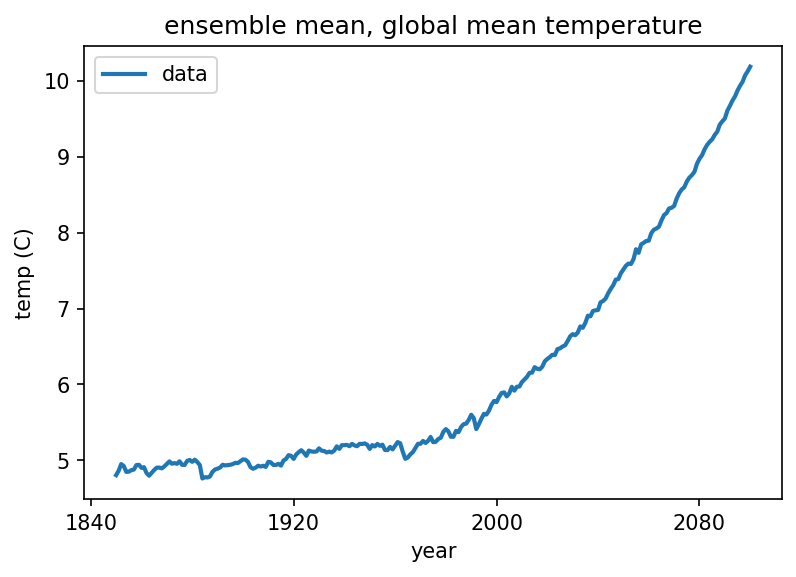

In [6]:
# compute the ensemble mean, global mean temperature
# these computations should be based on the training set only
da_ens = data_train.mean(axis=0)
weights = np.cos(np.deg2rad(da_ens.lat))
weights.name = "weights"
temp_weighted = da_ens.weighted(weights)
global_mean = temp_weighted.mean(("lon", "lat"))

# plot the calculation to make sure things make sense
global_mean.plot(linewidth=2,label='data',color="tab:blue")
plt.xlabel('year')
plt.ylabel('temp (C)')
plt.title('ensemble mean, global mean temperature')
plt.legend()
plt.show()


#### Define the labels for each sample as the number of years until the target is reached

In [7]:
# define the labels
labels = global_mean.values
print('labels = ' + str(labels))

# get years for each label/sample
years = data_val['time.year'].values

labels = [ 4.80220682  4.86024921  4.94766069  4.9234116   4.84513304  4.8479381
  4.86783718  4.87553398  4.93484019  4.93779653  4.89891823  4.90651941
  4.82916782  4.79477772  4.83139389  4.86956793  4.90065451  4.90182352
  4.89150016  4.91670567  4.9503611   4.98294898  4.95277403  4.96088311
  4.9517656   4.98458702  4.93874508  4.93633933  4.99007344  5.00210652
  4.97764628  5.00581302  4.97565416  4.93500431  4.75786678  4.77516666
  4.77081523  4.78500086  4.84657805  4.87662169  4.8883201   4.90258094
  4.93850199  4.93046109  4.93500111  4.93828614  4.94789898  4.96398712
  4.96139078  4.98635219  5.0097949   5.00577192  4.97635588  4.90616211
  4.88628392  4.90101232  4.92600019  4.91544553  4.92548954  4.91007837
  4.97815757  4.97023076  4.9360908   4.9364077   4.95033311  4.9278338
  4.99574602  5.01643006  5.0663062   5.05597972  5.01607774  5.07451479
  5.10561566  5.13068186  5.09858497  5.05651752  5.12630679  5.11428418
  5.11037934  5.11442654  5.15541646  5.1245

#### Organize the data into training / validation / testing sets

In [8]:
x_train = data_train.values.reshape((data_train.shape[0]*data_train.shape[1],data_train.shape[2]*data_train.shape[3]))
x_val   = data_val.values.reshape((data_val.shape[0]*data_val.shape[1],data_val.shape[2]*data_val.shape[3]))
x_test  = data_test.values.reshape((data_test.shape[0]*data_test.shape[1],data_test.shape[2]*data_test.shape[3]))

y_train = np.tile(labels,data_train.shape[0])
y_val   = np.tile(labels,data_val.shape[0])
y_test  = np.tile(labels,data_test.shape[0])

years_train = np.tile(years,data_train.shape[0])
years_val   = np.tile(years,data_val.shape[0])
years_test  = np.tile(years,data_test.shape[0])

print(x_train.shape, y_train.shape, years_train.shape)
print(x_val.shape, y_val.shape, years_val.shape)
print(x_test.shape, y_test.shape, years_test.shape)

(6777, 10368) (6777,) (6777,)
(753, 10368) (753,) (753,)
(753, 10368) (753,) (753,)


## Setup the network and associated callbacks

In [9]:

# define the model and its compile function
def compile_model(x_train):

    # First we start with an input layer
    inputs = Input(shape=x_train.shape[1:]) 

    normalizer = tf.keras.layers.Normalization()
    normalizer.adapt(x_train)
    layers = normalizer(inputs)

    layers = Dropout(rate=DROP_RATE,
                     seed=SEED)(layers) 
    
    for hidden, activation, ridge in zip(HIDDENS, ACTIVATIONS, RIDGE):
        layers = Dense(hidden, activation=activation,
                       kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.00, l2=ridge),
                       bias_initializer=tf.keras.initializers.RandomNormal(seed=SEED),
                       kernel_initializer=tf.keras.initializers.RandomNormal(seed=SEED))(layers)


    # Output layer has a softmax function to convert output to class likelihood
    output_layer = Dense(1, activation='linear',
                      bias_initializer=tf.keras.initializers.RandomNormal(seed=SEED),
                      kernel_initializer=tf.keras.initializers.RandomNormal(seed=SEED))(layers)

    # Constructing the model
    model = Model(inputs, output_layer)
    optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE) # Using the Adam optimizer
    model.compile(optimizer=optimizer, loss=LOSS, metrics=['mse',])

    model.summary()
    
    return model

## Train the network

2022-03-13 06:57:28.262707: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10368)]           0         
                                                                 
 normalization (Normalizatio  (None, 10368)            20737     
 n)                                                              
                                                                 
 dropout (Dropout)           (None, 10368)             0         
                                                                 
 dense (Dense)               (None, 5)                 51845     
                                                                 
 dense_1 (Dense)             (None, 5)                 30        
                                                                 
 dense_2 (Dense)             (None, 1)                 6         
                                                             

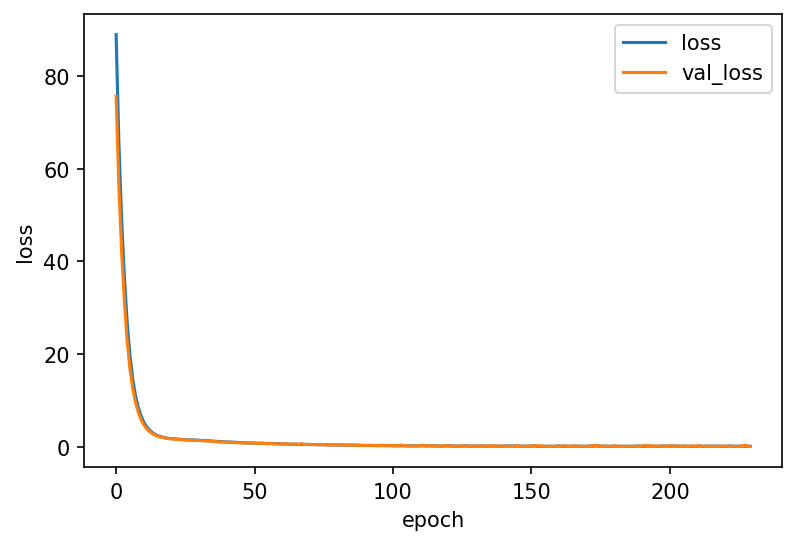

In [10]:
SEED = 8889
LEARNING_RATE = 0.0001
BATCH_SIZE = 64
NUM_EPOCHS = 10_000
HIDDENS = [5,5]
RIDGE = [.75, 0.]
DROP_RATE = 0.0
ACTIVATIONS = ['relu'] * len(HIDDENS) 
LOSS = 'mae'
PATIENCE = 30
VERBOSITY = 0
#----------------------------------------

tf.keras.backend.clear_session()            
tf.random.set_seed(SEED)
np.random.seed(SEED)

# define early stopping callback
EARLY_STOPPING = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                   patience=PATIENCE,
                                                   verbose=1,
                                                   mode='auto',
                                                   restore_best_weights=True)

model = compile_model(x_train)
history = model.fit(x_train, y_train, 
                    epochs=NUM_EPOCHS, 
                    verbose=VERBOSITY,
                    batch_size = BATCH_SIZE, 
                    shuffle=True,
                    validation_data=[x_val, y_val],
                    callbacks=[EARLY_STOPPING],
                   )
#----------------------------------------
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


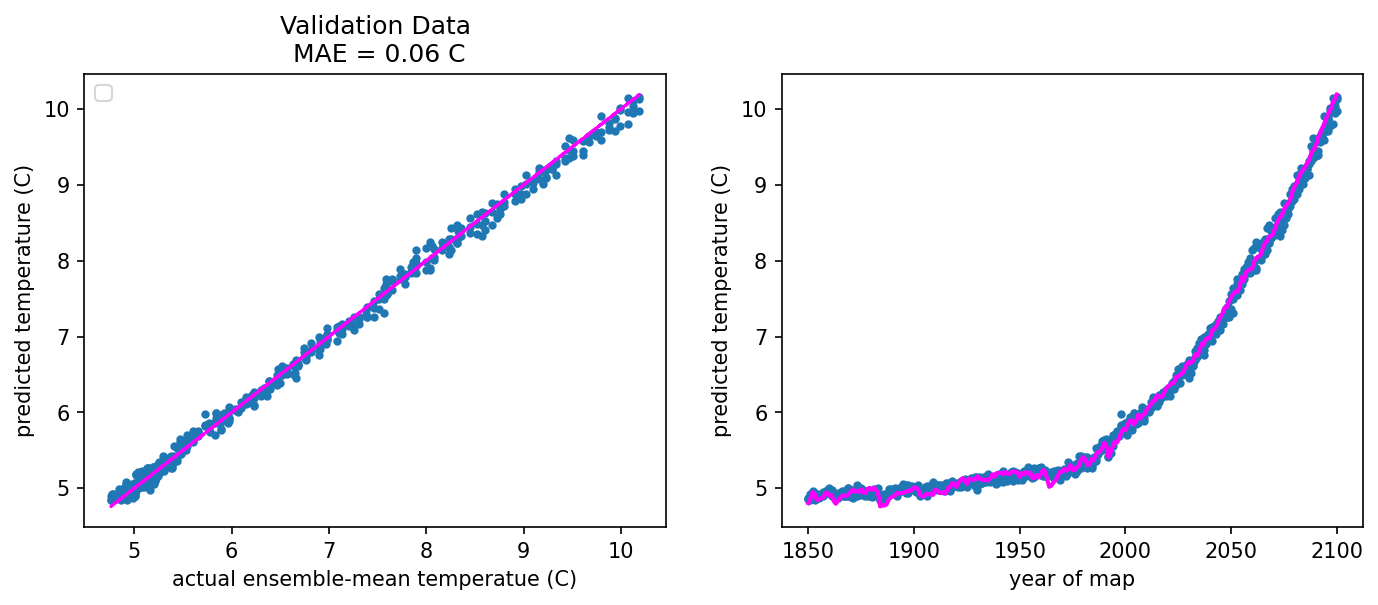

In [11]:
x_plot     = x_val #x_test #x_val
y_plot     = y_val #y_test #y_val
years_plot = years_val

predict_plot = model.predict(x_plot)
mae = np.mean(np.abs(predict_plot[:,0]-y_plot[:]))

#--------------------------------
plt.figure(figsize=(11,4))
plt.subplot(1,2,1)
plt.plot(y_plot, predict_plot,'.')
plt.plot(y_plot, y_plot, '--', color='fuchsia')

plt.legend()
plt.xlabel('actual ensemble-mean temperatue (C)')
plt.ylabel('predicted temperature (C)')
plt.title('Validation Data\n MAE = ' + str(np.round(mae,2)) + ' C')

#--------------------------------
plt.subplot(1,2,2)
plt.plot(years_plot, predict_plot,'.')
plt.plot(global_mean['time.year'].values, global_mean.values, color='fuchsia', linewidth=2)
plt.xlabel('year of map')
plt.ylabel('predicted temperature (C)')

if IN_COLAB==False:
    pass
    # plt.savefig('figures/initial_result_seed' + str(SEED) + '.png', dpi=savefig_dpi)
plt.show()

## Explainability via Input * Gradient and Integrated Gradients
We will use two attribution explainaiblity methods called Input * Gradient and Integrated Gradients to make heatmaps of regions of the input that act as explanations for the network's prediction.

* https://keras.io/examples/vision/integrated_gradients/
* https://distill.pub/2020/attribution-baselines/

In [12]:
def get_gradients(inputs, top_pred_idx=None):
    """Computes the gradients of outputs w.r.t input image.

    Args:
        inputs: 2D/3D/4D matrix of samples
        top_pred_idx: (optional) Predicted label for the x_data
                      if classification problem. If regression,
                      do not include.

    Returns:
        Gradients of the predictions w.r.t img_input
    """
    inputs = tf.cast(inputs, tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(inputs)
        
        # Run the forward pass of the layer and record operations
        # on GradientTape.
        preds = model(inputs, training=False)  
        
        # For classification, grab the top class
        if top_pred_idx is not None:
            preds = preds[:, top_pred_idx]
        
    # Use the gradient tape to automatically retrieve
    # the gradients of the trainable variables with respect to the loss.        
    grads = tape.gradient(preds, inputs)
    return grads

def get_integrated_gradients(inputs, baseline=None, num_steps=50, top_pred_idx=None):
    """Computes Integrated Gradients for a prediction.

    Args:
        inputs (ndarray): 2D/3D/4D matrix of samples
        baseline (ndarray): The baseline image to start with for interpolation
        num_steps: Number of interpolation steps between the baseline
            and the input used in the computation of integrated gradients. These
            steps along determine the integral approximation error. By default,
            num_steps is set to 50.
        top_pred_idx: (optional) Predicted label for the x_data
                      if classification problem. If regression,
                      do not include.            

    Returns:
        Integrated gradients w.r.t input image
    """
    # If baseline is not provided, start with zeros
    # having same size as the input image.
    if baseline is None:
        input_size = np.shape(inputs)[1:]
        baseline = np.zeros(input_size).astype(np.float32)
    else:
        baseline = baseline.astype(np.float32)

    # 1. Do interpolation.
    inputs = inputs.astype(np.float32)
    interpolated_inputs = [
        baseline + (step / num_steps) * (inputs - baseline)
        for step in range(num_steps + 1)
    ]
    interpolated_inputs = np.array(interpolated_inputs).astype(np.float32)

    # 3. Get the gradients
    grads = []
    for i, x_data in enumerate(interpolated_inputs):
        grad = get_gradients(x_data, top_pred_idx=top_pred_idx)
        grads.append(grad[0])
    grads = tf.convert_to_tensor(grads, dtype=tf.float32)

    # 4. Approximate the integral using the trapezoidal rule
    grads = (grads[:-1] + grads[1:]) / 2.0
    avg_grads = tf.reduce_mean(grads, axis=0)

    # 5. Calculate integrated gradients and return
    integrated_grads = (inputs - baseline) * avg_grads
    return integrated_grads

def random_baseline_integrated_gradients(inputs, num_steps=50, num_runs=5, top_pred_idx=None):
    """Generates a number of random baseline images.

    Args:
        inputs (ndarray): 2D/3D/4D matrix of samples
        num_steps: Number of interpolation steps between the baseline
            and the input used in the computation of integrated gradients. These
            steps along determine the integral approximation error. By default,
            num_steps is set to 50.
        num_runs: number of baseline images to generate
        top_pred_idx: (optional) Predicted label for the x_data
                      if classification problem. If regression,
                      do not include.      

    Returns:
        Averaged integrated gradients for `num_runs` baseline images
    """
    # 1. List to keep track of Integrated Gradients (IG) for all the images
    integrated_grads = []

    # 2. Get the integrated gradients for all the baselines
    for run in range(num_runs):
        baseline = np.zeros(np.shape(inputs)[1:])
        for i in np.arange(0,np.shape(random_baseline)[0]):
            j = np.random.choice(np.arange(0,np.shape(inputs)[0]))
            baseline[i] = inputs[j,i]

        igrads = get_integrated_gradients(
            inputs=inputs,
            baseline=baseline,
            num_steps=num_steps,
        )
        integrated_grads.append(igrads)

    # 3. Return the average integrated gradients for the image
    integrated_grads = tf.convert_to_tensor(integrated_grads)
    return tf.reduce_mean(integrated_grads, axis=0)



In [13]:
#=========================================
# Define the samples you want to explain
inputs = np.copy(x_val)
targets = np.copy(y_val)
years = np.copy(years_val)
preds = model.predict(inputs)
#=========================================

In [14]:
#---------------------------------------
# Gradient x Input
#---------------------------------------
# compute the multiplication of gradient * inputs
# and reshape into a map of latitude x longitude
grads = get_gradients(inputs).numpy()
grad_x_input = grads * inputs
grad_x_input = grad_x_input.reshape((len(targets),data_train.shape[2],data_train.shape[3]))
print(np.shape(grad_x_input))

(753, 72, 144)


In [16]:
#---------------------------------------
# Integrated Gradients
#---------------------------------------
BASELINE = 'zeros'#1850

# Alternative baselines
if(BASELINE=='zeros'):
    baseline_mean = np.mean(x_train,axis=0)*0.    
elif(BASELINE=='mean'):
    baseline_mean = np.mean(x_train,axis=0)  
else:
    baseline_mean = np.mean(data_train,axis=0)
    isample = np.where(data_train['time.year']==BASELINE)[0]
    baseline_mean = np.mean(baseline_mean[isample,:,:],axis=0).values
    baseline_mean = baseline_mean.reshape((baseline_mean.shape[0]*baseline_mean.shape[1]))

print('shape(baseline_mean) = ' + str(np.shape(baseline_mean)))
print('model.predict(baseline_mean) = ' + str(model.predict(baseline_mean[np.newaxis,:])))

igrad = get_integrated_gradients(inputs, baseline=baseline_mean)
integrated_gradients = igrad.numpy().reshape((len(targets),data_train.shape[2],data_train.shape[3]))
print(np.shape(integrated_gradients))

shape(baseline_mean) = (10368,)
model.predict(baseline_mean) = [[7.283002]]
(753, 72, 144)


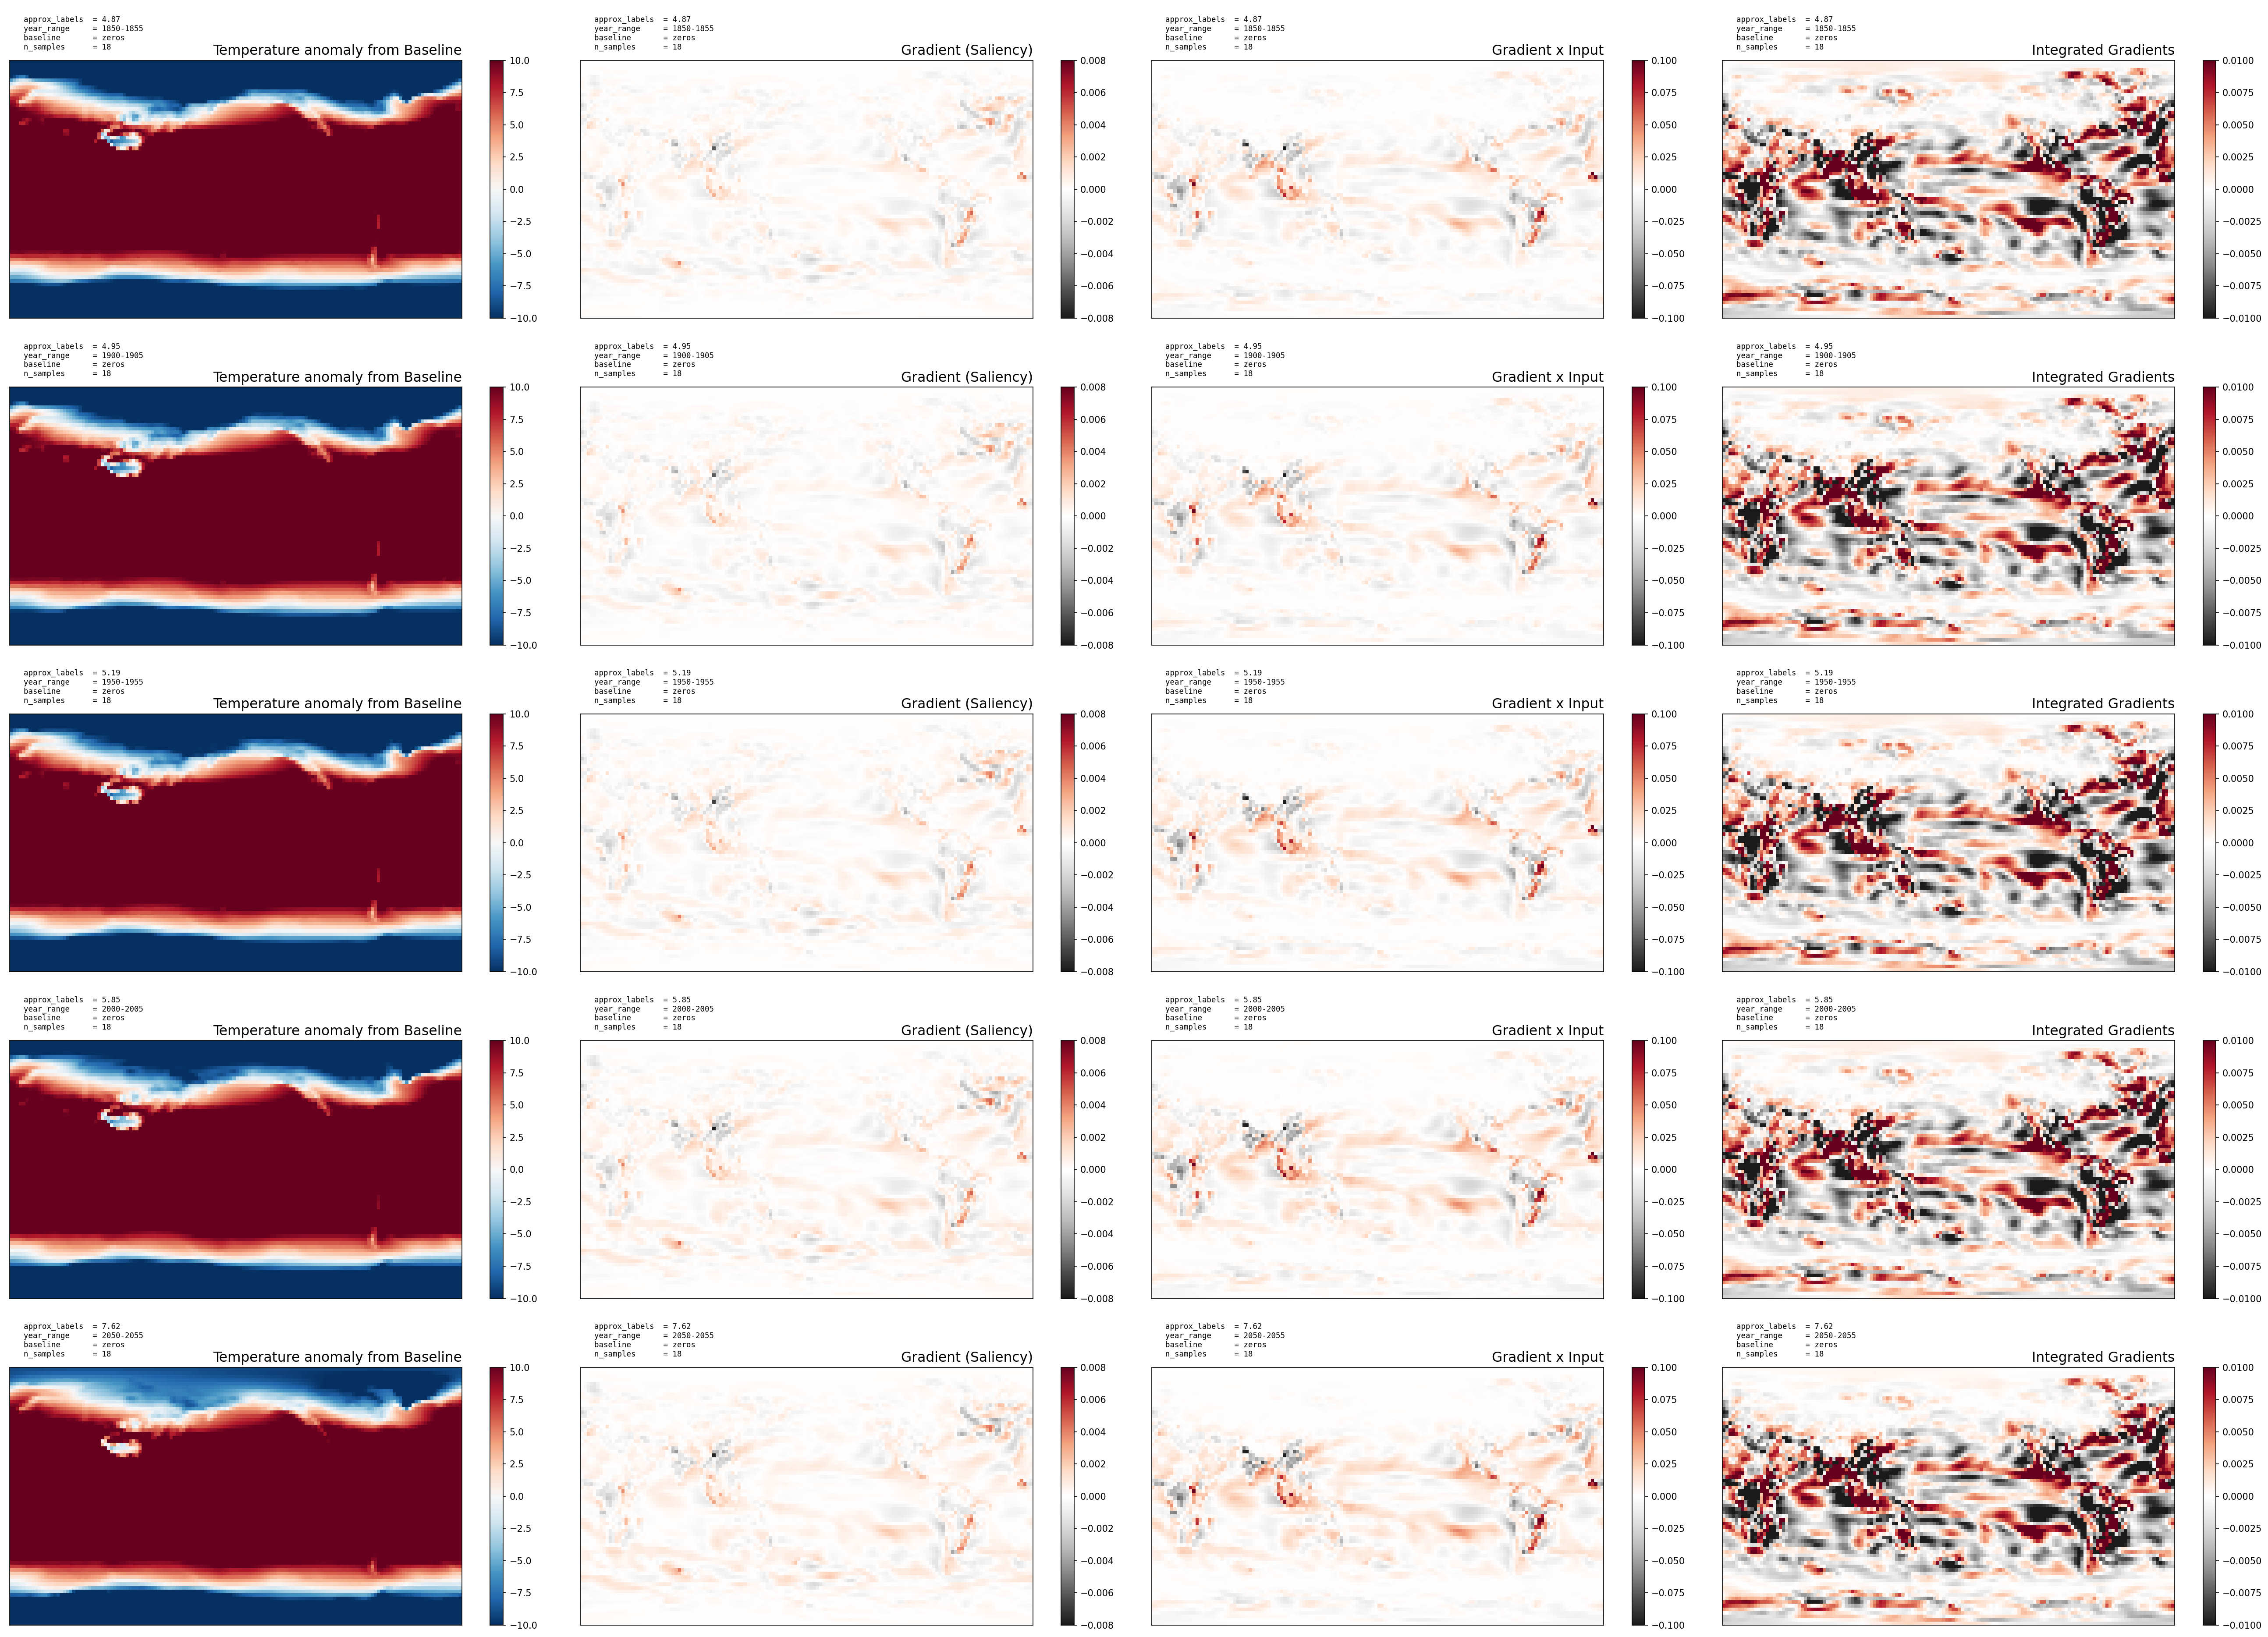

In [17]:
def plot_map(x, clim=None, title=None, text=None, cmap='RdGy_r'):
    if clim is None:
        plt.pcolor(x,
                   cmap=cmap,
                   norm=mpl.colors.CenteredNorm(),        
                  )
    else:
        plt.pcolor(x,
                   cmap=cmap,
                  )
    plt.clim(clim)
    plt.colorbar()
    plt.title(title,fontsize=15,loc='right')    
    plt.yticks([])
    plt.xticks([])
    
    plt.text(0.01, 1.0, text, fontfamily='monospace', fontsize='small', va='bottom',transform=plt.gca().transAxes)

# plot the resulting heatmaps for a subset of samples
# based on their label
plot_list = (1850, 1900, 1950, 2000, 2050)
NCOL = 4
plt.subplots(len(plot_list),NCOL,figsize=(35,5*len(plot_list)))

for irow,min_range in enumerate(plot_list):
        
    max_range = min_range + 5
    isamples = np.where((years >= min_range) & (years <= max_range))[0]
    igrad_mean = np.mean(integrated_gradients[isamples,:,:],axis=0)
    grad_x_input_mean = np.mean(grad_x_input[isamples,:,:],axis=0)
    grad_mean = np.mean(grads[isamples,:],axis=0).reshape((data_train.shape[2],data_train.shape[3]))
    x_inputs_mean = np.mean(inputs[isamples,:],axis=0).reshape((data_train.shape[2],data_train.shape[3]))
    x_inputs_mean = x_inputs_mean - baseline_mean.reshape((data_train.shape[2],data_train.shape[3]))
    #------------------------------------------------------------------
    
    text = (
            "\n"
            + f"  approx_labels  = {targets[isamples].mean().round(2)}\n"
            + f"  year_range     = {min_range}-{max_range}\n"        
            + f"  baseline       = {BASELINE}\n"                
            + f"  n_samples      = {len(isamples)}\n"
    )    
    #------------------------------------------------------------------    
    
    # plot average input map
    plt.subplot(len(plot_list),NCOL,irow*NCOL+1)
    plot_map(x_inputs_mean, 
             text=text,
             clim=(-10,10),
             cmap='RdBu_r',
             title = 'Temperature anomaly from Baseline',
            )
    #------------------------------------------------------------------
    # plot explainability of gradient (saliency)
    plt.subplot(len(plot_list),NCOL,irow*NCOL+2)
    plot_map(grad_mean, 
             text=text,             
             clim=(-0.008, .008), 
             title = 'Gradient (Saliency)',
            )
    
    #------------------------------------------------------------------
    # plot explainability of input x gradient
    plt.subplot(len(plot_list),NCOL,irow*NCOL+3)
    plot_map(grad_x_input_mean, 
             text=text,
             clim=(-.1,.1),
             title = 'Gradient x Input',
            )

    #------------------------------------------------------------------
    # plot explainability of integrated gradients
    plt.subplot(len(plot_list),NCOL,irow*NCOL+4)
    plot_map(igrad_mean, 
             text=text,             
             clim=(-.01,.01), 
             title = 'Integrated Gradients',
            )

plt.tight_layout()   
if IN_COLAB==False:
    plt.savefig('figures/baseline_example/xai_grid_' + str(min_range) +'-' + str(max_range) + '_baseline_' + str(BASELINE) + '.png', dpi=savefig_dpi)
plt.show()



## Predict obs

np.shape(x_obs) = (172, 10368)


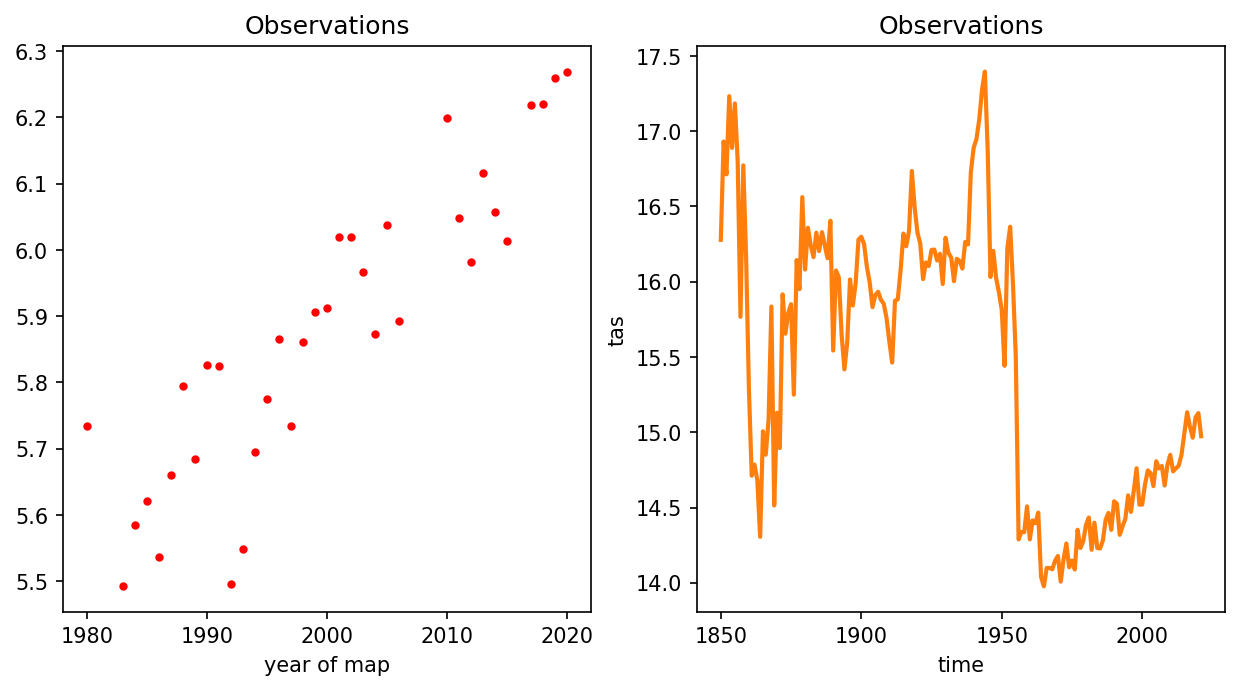

In [23]:
# nc_filename_obs = DATA_DIRECTORY + 'Land_and_Ocean_LatLong1_185001_202112_ann_mean_2pt5degree.nc'
# da_obs = xr.open_dataset(nc_filename_obs)['tas']  - 273.15
# # da_obs = da_obs.fillna(281.81423285)

# x_obs = da_obs.values.reshape((da_obs.shape[0],da_obs.shape[1]*da_obs.shape[2]))
# print('np.shape(x_obs) = ' + str(np.shape(x_obs)))
# y_predict_obs = model.predict(x_obs)

# #--------------------------------
# plt.figure(figsize=(10,5))
# plt.subplot(1,2,1)
# plt.plot(da_obs['time.year'], y_predict_obs, '.r')
# plt.xlabel('year of map')
# # plt.ylabel('predicted number of years until target is reached')
# plt.title('Observations')
# # plt.xlim(1850,2100)
# # plt.ylim(-20,40)
# # plt.axhline(y=0,color='gray')

# #--------------------------------
# plt.subplot(1,2,2)
# weights = np.cos(np.deg2rad(da_obs.lat))
# weights.name = "weights"
# temp_weighted = da_obs.weighted(weights)
# global_mean = temp_weighted.mean(("lon", "lat"))
# global_mean.plot(linewidth=2,label='data',color="tab:orange")
# plt.title('Observations')
# # plt.axhline(y=baseline_mean, color='k', linestyle='-', label='baseline temp')
# # plt.axhline(y=baseline_mean+TARGET_TEMP, color='tab:blue',linewidth=1., linestyle='--', label='target temp')
# # plt.axvline(x=target_year,color='tab:blue',linewidth=1., linestyle='--', label='target year')
# # plt.xlabel('year')
# # plt.ylabel('temp (K)')
# # plt.title(f + '\ntargets [' + str(target_year.year) + ', ' + str(TARGET_TEMP) + 'C]',
# #           fontsize = 8,
# #          )
# # plt.legend()
# plt.show()
